## Computer Vision

Классификация овощей на картинках. Всего дано 15 видов овощей.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

from collections import defaultdict
import copy
import random
import shutil
from urllib.request import urlretrieve

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import zipfile
from random import randint
from torch.utils.data import random_split
import re

In [2]:
# conda install -c conda-forge albumentations

In [3]:
# pip install -U albumentations

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# делаем импорт из модуля albumentations
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=200), # изображение с мин стороной имеет макс размер 200 (напр ширина у прям-ника)
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=180, width=180),
        # A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(brightness_limit = np.random.uniform(0.1, 0.2), 
                                    contrast_limit = np.random.uniform(0.1, 0.3), 
                                    always_apply = False, p = 0.3), # случ контрастность
        A.ColorJitter(brightness = np.random.uniform(0, 0.05), 
                      contrast = np.random.uniform(0, 0.05), 
                      saturation = np.random.uniform(0, 0.05), 
                      hue = np.random.uniform(0, 0.08), 
                      always_apply = False, p = 0.4),
        A.Transpose(always_apply = False, p = 0.5),
        A.ElasticTransform(alpha = randint(1,2), sigma = randint(1,2), 
                            alpha_affine = random.uniform(0.1, 0.2), 
                            interpolation = randint(0, 1), 
                            border_mode = randint(0, 1), 
                            value = np.random.uniform(0, 1), 
                            mask_value = np.random.uniform(0, 1),
                            always_apply = False, p = 0.5),
        A.ShiftScaleRotate(shift_limit = np.random.uniform(0, 0.15), 
                        scale_limit = np.random.uniform(0, 0.15), 
                        always_apply = False, p = 0.5),
        A.Blur(blur_limit = (3, 3), always_apply = False, p = 0.1),
        A.GaussNoise(var_limit = np.random.uniform(0.0001, 0.1), 
                  mean = np.random.uniform(0.0001, 0.1),
                  always_apply = False, p = 0.5),
        A.GaussianBlur(blur_limit = (3, 3), sigma_limit = randint(1, 5), 
                    always_apply = False, p = 0.5),
        
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.Resize(224, 224, interpolation = 0, always_apply=True),
        ToTensorV2(),
    ]
)


test_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=200),
        A.CenterCrop(height=180, width=180),
        A.Resize(224, 224, always_apply=True),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [6]:
# Открытие файла с трейном
class AlbumentationsImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None, target_transform=None):
        super().__init__(root, transform, target_transform)

    def __getitem__(self, index):
        path, target = self.samples[index]
        image = Image.open(path).convert('RGB')

        if self.transform is not None:
            image = self.transform(image=np.array(image))['image']
        
        if self.target_transform is not None:
            target = self.target_transform(target)

        return image, target


In [7]:
# открытие файла с тестом с учетом нумерации картинок
class TestImageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root_dir = root
        self.transform = transform
        files = os.listdir(root)
        files_with_numbers = [(file, int(re.search(r'\d+', file).group())) for file in files if os.path.isfile(os.path.join(root, file)) and re.search(r'\d+', file)]
        
        # Сортируем файлы по числам в названиях
        sorted_files = [file[0] for file in sorted(files_with_numbers, key=lambda x: x[1])]
        self.images = sorted_files

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name)
        image_np = np.array(image)

        if self.transform:
            image = self.transform(image=image_np)['image']

        return image, img_name

In [8]:
# Добавьте директорию к файлу data.zip, где хранятся трейн и тест!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# Распаковка архива data.zip
data_zip_path = "data.zip"
data_extract_dir = "data"
with zipfile.ZipFile(data_zip_path, 'r') as data_zip_ref:
    data_zip_ref.extractall(data_extract_dir)

In [9]:
# Добавьте путь к новой разархивированной папке с данными!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# Создание датасетов для обучающей и тестовой выборок
# train_dataset = datasets.ImageFolder(root=data_dir+'\\train', transform=train_transform)
train_dataset = AlbumentationsImageFolder(root='data/train', transform=train_transform)
test_dataset = TestImageDataset(root='data/test', transform=test_transform)

In [10]:
# Определение размера валидационного набора данных (например, 8%)
validation_size = int(0.08 * len(train_dataset))
train_size = len(train_dataset) - validation_size

# Разделение датасета
train_data, validation_data = random_split(train_dataset, [train_size, validation_size])

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)

dataloaders = {'train': train_loader, 'validation': validation_loader}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


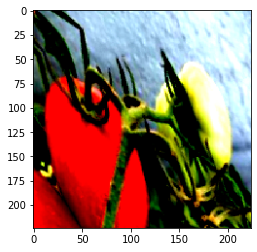

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 14


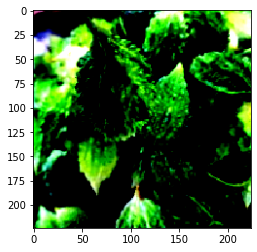

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 1


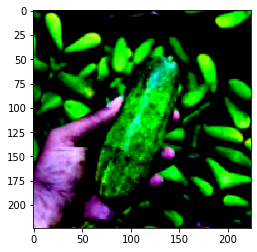

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 9


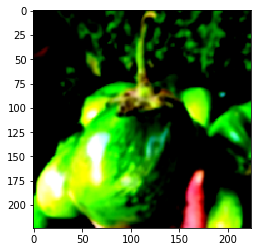

Label: 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


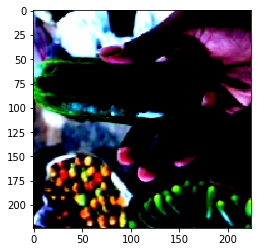

Label: 9


In [11]:
# отрисовка рандомных картинок

def imshow(img):
    # img = img / 2 + 0.5  # денормализовать изображение
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Получение первого батча изображений
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Вывод первых 5 изображений
for i in range(5):
    imshow(images[i])
    print(f'Label: {labels[i]}')

In [12]:
dataset_sizes = {'train': train_size,
                'validation': validation_size}

def train_model(model, criterion, optimizer, scheduler, epochs=5):

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_accuracy = 0.0

        for epoch in range(epochs):
            print(f'Epoch {epoch}/{epochs - 1}')
            print('-' * 10)

            # Каждую эпоху обучаем модель на тренировочном и проверяем на валидационном
            for operation in ['train', 'validation']:
                if operation == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                current_loss = 0.0
                current_accuracy = 0

                for images, labels in dataloaders[operation]:
                    images = images.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(operation == 'train'):
                        outputs = model(images)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if operation == 'train':
                            loss.backward()
                            optimizer.step()

                    # вычисляем ошибку и точность
                    current_loss += loss.item() * images.size(0)
                    current_accuracy += torch.sum(preds == labels.data)
                if operation == 'train':
                    scheduler.step()

                total_loss = current_loss / dataset_sizes[operation]
                total_accuracy = current_accuracy.double() / dataset_sizes[operation]

                print(f'{operation} Loss: {total_loss:.4f} Acc: {total_accuracy:.4f}')

                # deep copy the model
                if operation == 'validation' and total_accuracy > best_accuracy:
                    best_accuracy = total_accuracy
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        print(f'Best validation Accuracy: {best_accuracy:4f}')

        # загрузить веса лучшей модели
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [13]:
model_fine_tuning = models.densenet121(weights='IMAGENET1K_V1') # densenet121

# # Изменение последнего слоя модели resnet18 
# num_fine_tuningrs = model_fine_tuning.fc.in_features
# model_fine_tuning.fc = nn.Linear(num_fine_tuningrs, 15) # в начале добавляем слой с 15ю выходными слоями, тк у нас всего 15 классов

# # Изменение последнего слоя модели DenseNet
model_fine_tuning.classifier = torch.nn.Linear(model_fine_tuning.classifier.in_features, 15)

model_fine_tuning = model_fine_tuning.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_fine_tuning = optim.Adam(model_fine_tuning.parameters(), lr=0.001)

scheduler = lr_scheduler.StepLR(optimizer_fine_tuning, step_size=3, gamma=0.1)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /tmp/xdg_cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 62.4MB/s]


In [14]:
model_vegetables = train_model(model_fine_tuning, criterion, optimizer_fine_tuning, scheduler,
                       epochs=7)

Epoch 0/6
----------
train Loss: 0.1735 Acc: 0.9496
validation Loss: 0.4560 Acc: 0.8833

Epoch 1/6
----------
train Loss: 0.0732 Acc: 0.9775
validation Loss: 0.0219 Acc: 0.9938

Epoch 2/6
----------
train Loss: 0.0385 Acc: 0.9882
validation Loss: 0.0493 Acc: 0.9840

Epoch 3/6
----------
train Loss: 0.0130 Acc: 0.9967
validation Loss: 0.0063 Acc: 0.9972

Epoch 4/6
----------
train Loss: 0.0054 Acc: 0.9986
validation Loss: 0.0037 Acc: 0.9986

Epoch 5/6
----------
train Loss: 0.0039 Acc: 0.9994
validation Loss: 0.0031 Acc: 0.9986

Epoch 6/6
----------
train Loss: 0.0028 Acc: 0.9994
validation Loss: 0.0021 Acc: 0.9993

Best validation Accuracy: 0.999306


In [15]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
model_vegetables = model_vegetables.eval()
        
predicted_classes = [] 
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model_vegetables(images)
        _, predicted = torch.max(outputs, 1)
        predicted = predicted.cpu().detach().numpy().squeeze()
        predicted_classes.append(predicted)

In [16]:
import itertools
predicted_classes
flat_list = list(itertools.chain(*predicted_classes))

In [17]:
sub = pd.DataFrame({"id": list(range(3000)), "prediction": flat_list})
sub.to_csv('sample_submission.csv',index=False)
# файл скачается в ту же папку, где находится программный код